<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-проверка-данных" data-toc-modified-id="Загрузка-и-проверка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и проверка данных</a></span></li><li><span><a href="#Очистка-и-лемматизация" data-toc-modified-id="Очистка-и-лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка и лемматизация</a></span></li><li><span><a href="#Разделение-признаков" data-toc-modified-id="Разделение-признаков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разделение признаков</a></span></li><li><span><a href="#Сэмплирование" data-toc-modified-id="Сэмплирование-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Сэмплирование</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Модель-дерева-решений" data-toc-modified-id="Модель-дерева-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель дерева решений</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Бустинговая-модель-LGBM" data-toc-modified-id="Бустинговая-модель-LGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Бустинговая модель LGBM</a></span></li><li><span><a href="#Бустинговая-модель-CatBoost" data-toc-modified-id="Бустинговая-модель-CatBoost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Бустинговая модель CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка и проверка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

import re
import spacy
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

import warnings

In [2]:
# Загрузим данные
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

display(toxic_comments.head())
print('-' * 40)
print(toxic_comments.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


Данные содержат 159292 наблюдения. В столбце `text` находятся тексты, в столбце `toxic` - целевой признак (разметка о токсичности текстов). Прежде всего проверим данные на наличие пропусков и дубликатов.

In [3]:
# Проверка на наличие пропусков
print(f'Количество пропущенных значений: \n{toxic_comments.isna().sum()}')

print('-' * 40)

# Проверка на наличие дубликатов
print(f'Количество дубликатов: {toxic_comments.duplicated().sum()}')

Количество пропущенных значений: 
text     0
toxic    0
dtype: int64
----------------------------------------
Количество дубликатов: 0


Пропусков и дубликатов в данных нет.  
Проверим распределение целевого признака.

In [4]:
# Проверим, какие значения в столбце с целевым признаком и их количество
toxic_comments['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Токсичность - целевой признак, он находится в столбце `toxic`. Метка `токсично` обозначена как `1`, метка `не токсично` обозначена как `0`, то есть целевой признак бинарный. Изобразим распределение целевого признака графически.

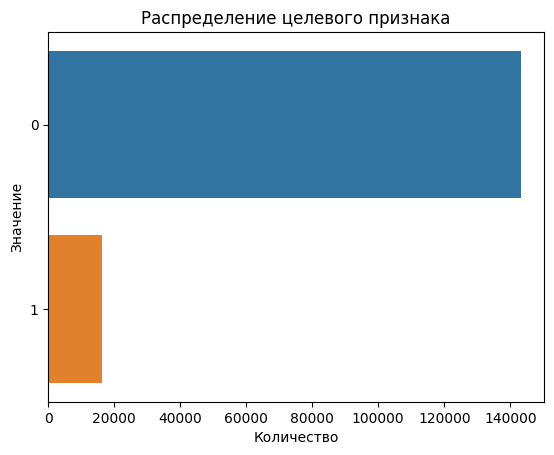

In [5]:
ax = sns.countplot(data=toxic_comments, y='toxic')
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Количество')
ax.set_ylabel('Значение')
pass

In [6]:
toxic_comments.toxic.value_counts().max() / toxic_comments.toxic.value_counts().min()

8.841344371679229

Данные, как видно на графике, несбалансированы. Значений `0` почти в 9 раз больше, чем значений `1`. На несбалансированных данных модели будут плохо предсказывать минорный класс. Чтобы модели работали адекватно, нужно решить проблему дисбаланса классов. Для этого, во-первых, при разделении выборок на тренировочную и тестовую необходимо использовать стратификацию, а во-вторых, надо либо выполнить сэмплирование тренировочной выборки, либо при инициализации моделей указать, что данные несбалансированы.  
Но сначала выполним очистку и лемматизацию текстов.

### Очистка и лемматизация

In [7]:
# Создадим класс для лемматизации
nlp = spacy.load("en_core_web_sm")

In [8]:
# Создадим функцию для очистки и лемматизации
def prepare(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    text_lem = ' '.join([w.lemma_ for w in clean])
    return text_lem

In [9]:
# Проверим корректность работы функции
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])

print(df_my)
print()
print(df_my['text'].apply(prepare))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked

0    the stripe bat be hang on their foot for good
1        you should be ashamed of yourself go work
Name: text, dtype: object


Добавим в наш датафрейм `toxic_comments` столбец с лемматизированным текстом. Поскольку процесс лемматизации каждого токена длительный, для контроля времени лемматизации применим индикатор прогресса `progress_apply`.

In [10]:
tqdm.pandas()

toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(prepare)
toxic_comments.head()
#data['lemm_text'] = data['text'].progress_apply(lemmatize)

100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [52:15<00:00, 50.80it/s]


,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


### Разделение признаков

In [11]:
# Зададим константу
RANDOM_STATE = 42

# Выделим признаки и таргет
features = toxic_comments.drop(['toxic'], axis = 1)
target = toxic_comments['toxic']

# Выделим тренировочную и валидационно-тестовую выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=target
)

# Выделим валидационную и тестовую выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test,
    target_valid_test,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=target_valid_test
)

# Проверим размеры выборок
print(features_train.shape)
print(target_train.shape)
print()

print(features_valid.shape)
print(target_valid.shape)
print()

print(features_test.shape)
print(target_test.shape)

(111504, 2)
(111504,)

(23894, 2)
(23894,)

(23894, 2)
(23894,)


### Сэмплирование

Для борьбы с дисбалансом классов выполним андерсэмплинг, так как количество данных позволяет это сделать. Сэмплируем только тренировочные выборки.

In [12]:
# проверка баланса данных в исходном датасете
print(f'Тренировочные данные до сэмплирования:\n{target_train.value_counts()}')

# Вычисляем размер дисбаланса: узнаем, насколько данных мажорного класса больше
delta = target_train.value_counts().max() - target_train.value_counts().min()

# Отбираем случайные объекты мажорного класса для удаления
deleted_index = target_train.loc[target_train == 0].sample(delta).index

# удаляем наблюдения мажорного класса и сохраняем итоговые выборки
features_train_sampled = features_train[~features_train.index.isin(deleted_index)]
target_train_sampled = target_train[~target_train.index.isin(deleted_index)]

# проверка баланса данных в сэмплированном датасете
print(f'\nТренировочные данные после сэмплирования:\n{target_train_sampled.value_counts()}') 

Тренировочные данные до сэмплирования:
toxic
0    100174
1     11330
Name: count, dtype: int64

Тренировочные данные после сэмплирования:
toxic
0    11330
1    11330
Name: count, dtype: int64


In [13]:
# Итоговый размер тренировочных выборок
print(features_train_sampled.shape)
print(target_train_sampled.shape)

(22660, 2)
(22660,)


### Создание признаков

Теперь тренировочные данные сбалансированы. Создаём признаки для обучения.

In [14]:
# Загрузим список стоп-слов, создадим список английских стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# Создаём счётчик, указав в нём стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zibar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Создаём корпусы текстов
corpus_train = features_train_sampled['lemm_text']
corpus_valid = features_valid['lemm_text']
corpus_test = features_test['lemm_text']

In [16]:
# Получаем признаки в векторном представлении
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

# Проверим размеры тренировочных выборок в векторном виде
print(tf_idf_train.shape)
print(tf_idf_valid.shape)
print(tf_idf_test.shape)

(22660, 44735)
(23894, 44735)
(23894, 44735)


Кроме того, существует возможность не применять сэмплирование, а при инициализации некоторых моделей можно указывать, что классы нужно сбалансировать. Поэтому подготовим второй вариант данных, без сэмплирования.

In [17]:
# Проверим размеры выборок
print(features_train.shape)
print(target_train.shape)
print()

print(features_valid.shape)
print(target_valid.shape)
print()

print(features_test.shape)
print(target_test.shape)

(111504, 2)
(111504,)

(23894, 2)
(23894,)

(23894, 2)
(23894,)


In [18]:
# Создаём корпусы текстов (без сэмплирования)
corpus_train_ns = features_train['lemm_text']
corpus_valid_ns = features_valid['lemm_text']
corpus_test_ns = features_test['lemm_text']

# Получаем признаки в векторном представлении (без сэмплирования)
tf_idf_train_ns = count_tf_idf.fit_transform(corpus_train_ns)
tf_idf_valid_ns = count_tf_idf.transform(corpus_valid_ns)
tf_idf_test_ns = count_tf_idf.transform(corpus_test_ns)

# Проверим размеры тренировочных выборок в векторном виде
print(tf_idf_train_ns.shape)
print(tf_idf_valid_ns.shape)
print(tf_idf_test_ns.shape)

(111504, 129478)
(23894, 129478)
(23894, 129478)


Итак, данные загружены, проверены на наличие пропусков и дубликатов. Тексты очищены и лемматизированы. Данные разделены на тренировочную, валидационную и тестовую выборки. Выявлен дисбаланс классов целевого признака, проблема дисбаланса решена с помощью андерсэмплинга. Загружен список стоп-слов, созданы мешки слов, исключив стоп-слова.  

Кроме того, подготовлены выборки для обучения моделей без сэмплирования.

Для обучения и тестирования моделей наши данные разделены на выборки: тренировочные `tf_idf_train` и `target_train_sampled`, валидационные `tf_idf_valid` и `target_valid`, тестовые `tf_idf_test` и `target_test`. Кроме того, данные без сэмплирования: тренировочные `tf_idf_train_ns` и `target_train`, валидационные `tf_idf_valid_ns` и `target_valid`, тестовые `tf_idf_test_ns` и `target_test`.  

Гиперпараметры будем подбирать вручную.

## Обучение

### Логистическая регрессия

In [19]:
# Напишем формулу для обучения моделей

def learning_model(model_name, model, X_train, X_valid, y_train, y_valid):
    
    # обучаем модель
    model.fit(X_train, y_train)
    
    # предсказания для X_valid
    pred = model.predict(X_valid)
    
    # получаем значения метрики F1 для модели
    f1 = round(f1_score(y_valid, pred), 2)
    
    # выводим на экран метрику F1
    print(f'Метрика F1 модели {model_name}: {f1}')
    
    # результат работы модели
    return f1

In [20]:
# Инициализация и обучение модели логистической регрессии с гиперпараметрами по умолчанию
model_name_lr = "LR"
model_lr = LogisticRegression(random_state=RANDOM_STATE)

f1_lr = learning_model(model_name_lr, model_lr, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели LR: 0.67


In [21]:
# Попробуем подобрать гиперпараметры для модели логистической регрессии
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 1)
model_name_lr_1 = "LR, penalty='l1', C=0.5"
model_lr_1 = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=0.5,
    random_state=RANDOM_STATE)

f1_lr_1 = learning_model(model_name_lr_1, model_lr_1, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели LR, penalty='l1', C=0.5: 0.72


In [22]:
warnings.filterwarnings("ignore")

In [23]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 2)
model_name_lr_2 = "LR, penalty='l1', C=5"
model_lr_2 = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=5,
    random_state=RANDOM_STATE)

f1_lr_2 = learning_model(model_name_lr_2, model_lr_2, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели LR, penalty='l1', C=5: 0.69


In [24]:
# Инициализация и обучение модели с новыми гиперпараметрами (вариант 3)
model_name_lr_3 = "LR, penalty='elasticnet', C=8"
model_lr_3 = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.8,
    C=8,
    random_state=RANDOM_STATE)

f1_lr_3 = learning_model(model_name_lr_3, model_lr_3, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели LR, penalty='elasticnet', C=8: 0.69


Рассмотрим вариант без сэмплирования, указав в настройках модели, что нужно обратить внимание на несбалансированность классов.

In [25]:
# Инициализация и обучение модели логистической регрессии без сэмплирования с гиперпараметрами по умолчанию
model_name_lr_ns = "LR_ns"
model_lr_ns = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_STATE)

f1_lr_ns = learning_model(model_name_lr_ns, model_lr_ns, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели LR_ns: 0.75


In [26]:
# Инициализация и обучение модели без сэмплирования с новыми гиперпараметрами (вариант 1)
model_name_lr_ns_1 = "LR_ns, penalty='l1', C=0.5"
model_lr_ns_1 = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=0.5,
    class_weight='balanced',
    random_state=RANDOM_STATE)

f1_lr_ns_1 = learning_model(model_name_lr_ns_1, model_lr_ns_1, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели LR_ns, penalty='l1', C=0.5: 0.7


In [27]:
# Инициализация и обучение модели без сэмплирования с новыми гиперпараметрами (вариант 2)
model_name_lr_ns_2 = "LR_ns, penalty='l2', C=10"
model_lr_ns_2 = LogisticRegression(
    C=10,
    class_weight='balanced',
    random_state=RANDOM_STATE)

f1_lr_ns_2 = learning_model(model_name_lr_ns_2, model_lr_ns_2, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели LR_ns, penalty='l2', C=10: 0.76


In [28]:
# Инициализация и обучение модели без сэмплирования с новыми гиперпараметрами (вариант 3)
model_name_lr_ns_3 = "LR_ns, penalty='l1', C=10"
model_lr_ns_3 = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=10,
    class_weight='balanced',
    random_state=RANDOM_STATE)

f1_lr_ns_3 = learning_model(model_name_lr_ns_3, model_lr_ns_3, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели LR_ns, penalty='l1', C=10: 0.72


In [29]:
results_lr = {
    'model': [
        model_name_lr,
        model_name_lr_1,
        model_name_lr_2,
        model_name_lr_3,
        model_name_lr_ns,
        model_name_lr_ns_1,
        model_name_lr_ns_2,
        model_name_lr_ns_3
    ],
    'F1': [f1_lr, f1_lr_1, f1_lr_2, f1_lr_3, f1_lr_ns, f1_lr_ns_1, f1_lr_ns_2, f1_lr_ns_3]
}

def model_results(results):
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='F1', ascending=False).reset_index(drop=True)
    return results_df

result_lr = model_results(results_lr)
result_lr

,model,F1
0,"LR_ns, penalty='l2', C=10",0.76
1,LR_ns,0.75
2,"LR, penalty='l1', C=0.5",0.72
3,"LR_ns, penalty='l1', C=10",0.72
4,"LR_ns, penalty='l1', C=0.5",0.70
5,"LR, penalty='l1', C=5",0.69
6,"LR, penalty='elasticnet', C=8",0.69
7,LR,0.67


Модель логистической регрессии лучше всего отработала на несэмплированных данных с гиперпараметрами `penalty='l2'`, `C=10`. Значение метрики `F1` составило 0,76. Кроме того, модель с гиперпараметрами по умолчанию на данных без сэмплирования также отработала хорошо. Значение метрики `F1` составило 0,75.

### Модель дерева решений

In [30]:
# С гиперпараметрами по умолчанию
model_name_dtc = "DTC"
model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

f1_dtc = learning_model(model_name_dtc, model_dtc, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели DTC: 0.53


In [31]:
# С изменёнными гиперпараметрами (вариант 1)
model_name_dtc_1 = "DTC, max_depth=4, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=50"
model_dtc_1 = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=3,
    max_leaf_nodes=50,
    random_state=RANDOM_STATE)

f1_dtc_1 = learning_model(model_name_dtc_1, model_dtc_1, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели DTC, max_depth=4, min_samples_split=2, min_samples_leaf=3, max_leaf_nodes=50: 0.24


In [32]:
# С изменёнными гиперпараметрами (вариант 2)
model_name_dtc_2 = "DTC, max_depth=6"
model_dtc_2 = DecisionTreeClassifier(
    max_depth=6,
    random_state=RANDOM_STATE)

f1_dtc_2 = learning_model(model_name_dtc_2, model_dtc_2, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели DTC, max_depth=6: 0.48


In [33]:
# С изменёнными гиперпараметрами (вариант 3)
model_name_dtc_3 = "DTC, max_depth=8"
model_dtc_3 = DecisionTreeClassifier(
    max_depth=8,
    random_state=RANDOM_STATE)

f1_dtc_3 = learning_model(model_name_dtc_3, model_dtc_3, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели DTC, max_depth=8: 0.52


In [34]:
# Без сэмплирования с гиперпараметрами по умолчанию
model_name_dtc_ns = "DTC_ns"
model_dtc_ns = DecisionTreeClassifier(random_state=RANDOM_STATE)

f1_dtc_ns = learning_model(model_name_dtc_ns, model_dtc_ns, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели DTC_ns: 0.71


In [35]:
# Без сэмплирования с новыми гиперпараметрами
model_name_dtc_ns_1 = "DTC_ns, max_depth=8"
model_dtc_ns_1 = DecisionTreeClassifier(max_depth=8, random_state=RANDOM_STATE)

f1_dtc_ns_1 = learning_model(model_name_dtc_ns_1, model_dtc_ns_1, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели DTC_ns, max_depth=8: 0.58


In [36]:
results_dtc = {
    'model': [model_name_dtc,
              model_name_dtc_1,
              model_name_dtc_2,
              model_name_dtc_3,
              model_name_dtc_ns,
              model_name_dtc_ns_1
             ],
    'F1': [f1_dtc, f1_dtc_1, f1_dtc_2, f1_dtc_3, f1_dtc_ns, f1_dtc_ns_1]
}

result_dtc = model_results(results_dtc)
result_dtc

,model,F1
0,DTC_ns,0.71
1,"DTC_ns, max_depth=8",0.58
2,DTC,0.53
3,"DTC, max_depth=8",0.52
4,"DTC, max_depth=6",0.48
5,"DTC, max_depth=4, min_samples_split=2, min_sam...",0.24


Дерево решений отработало лучше всего на несэмплированных данных с гиперпараметрами по умолчанию, значение метрики `F1` составило 0,71.

### Модель случайного леса

In [37]:
# С гиперпараметрами по умолчанию
model_name_rfc = "RFC"
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

f1_rfc = learning_model(model_name_rfc, model_rfc, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели RFC: 0.67


In [38]:
# С новыми гиперпараметрами (вариант 1)
model_name_rfc_1 = "RFC, n_estimators=200, max_depth=30"
model_rfc_1 = RandomForestClassifier(
    n_estimators = 200,
    max_depth=30,
    random_state=RANDOM_STATE)

f1_rfc_1 = learning_model(model_name_rfc_1, model_rfc_1, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели RFC, n_estimators=200, max_depth=30: 0.44


In [39]:
# С новыми гиперпараметрами (вариант 2)
model_name_rfc_2 = "RFC, n_estimators=300, max_depth=20"
model_rfc_2 = RandomForestClassifier(
    n_estimators = 300,
    max_depth=20,
    random_state=RANDOM_STATE)

f1_rfc_2 = learning_model(model_name_rfc_2, model_rfc_2, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели RFC, n_estimators=300, max_depth=20: 0.41


In [40]:
# Без сэмплирования с гиперпараметрами по умолчанию
model_name_rfc_ns = "RFC_ns"
model_rfc_ns = RandomForestClassifier(random_state=RANDOM_STATE)

f1_rfc_ns = learning_model(model_name_rfc_ns, model_rfc_ns, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели RFC_ns: 0.69


In [41]:
results_rfc = {
    'model': [model_name_rfc,
              model_name_rfc_1,
              model_name_rfc_2,
              model_name_rfc_ns
             ],
    'F1': [f1_rfc, f1_rfc_1, f1_rfc_2, f1_rfc_ns]
}

result_rfc = model_results(results_rfc)
result_rfc

,model,F1
0,RFC_ns,0.69
1,RFC,0.67
2,"RFC, n_estimators=200, max_depth=30",0.44
3,"RFC, n_estimators=300, max_depth=20",0.41


Модель случайного леса лучше всего работает с гиперпараметрами по умолчанию на несэмплированных данных, метрика F1 принимает значение 0,69.

### Бустинговая модель LGBM

In [43]:
# С гиперпараметрами по умолчанию
model_name_lgbm = "LGBM"
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

f1_lgbm = learning_model(model_name_lgbm, model_lgbm, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

[LightGBM] [Info] Number of positive: 11330, number of negative: 11330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.393861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122774
[LightGBM] [Info] Number of data points in the train set: 22660, number of used features: 3011
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Метрика F1 модели LGBM: 0.73


In [44]:
# С изменёнными гиперпараметрами (вариант 1)
model_name_lgbm_1 = "LGBM, n_estimators=150, max_depth=2"
model_lgbm_1 = LGBMClassifier(
    n_estimators=150,
    max_depth=2,
    random_state=RANDOM_STATE)

f1_lgbm_1 = learning_model(model_name_lgbm_1, model_lgbm_1, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

[LightGBM] [Info] Number of positive: 11330, number of negative: 11330
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122774
[LightGBM] [Info] Number of data points in the train set: 22660, number of used features: 3011
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Метрика F1 модели LGBM, n_estimators=150, max_depth=2: 0.69


In [45]:
# С изменёнными гиперпараметрами (вариант 2)
model_name_lgbm_2 = "LGBM, n_estimators=200, max_depth=5, num_leaves=64"
model_lgbm_2 = LGBMClassifier(
    n_estimators=200,
    max_depth=5,
    num_leaves=64,
    random_state=RANDOM_STATE)

f1_lgbm_2 = learning_model(model_name_lgbm_2, model_lgbm_2, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

[LightGBM] [Info] Number of positive: 11330, number of negative: 11330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.360806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122774
[LightGBM] [Info] Number of data points in the train set: 22660, number of used features: 3011
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [46]:
# С гиперпараметрами по умолчанию на несэмплированных данных
model_name_lgbm_ns = "LGBM_ns"
model_lgbm_ns = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)

f1_lgbm_ns = learning_model(model_name_lgbm_ns, model_lgbm_ns, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

[LightGBM] [Info] Number of positive: 11330, number of negative: 100174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.568216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491754
[LightGBM] [Info] Number of data points in the train set: 111504, number of used features: 9230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Метрика F1 модели LGBM_ns: 0.75


In [47]:
# С изменёнными гиперпараметрами на несэмплированных данных
model_name_lgbm_ns_1 = "LGBM_ns, n_estimators=150, max_depth=2"
model_lgbm_ns_1 = LGBMClassifier(
    class_weight='balanced',
    n_estimators=150,
    max_depth=2,
    random_state=RANDOM_STATE)

f1_lgbm_ns_1 = learning_model(
    model_name_lgbm_ns_1, model_lgbm_ns_1, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

[LightGBM] [Info] Number of positive: 11330, number of negative: 100174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.679683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491754
[LightGBM] [Info] Number of data points in the train set: 111504, number of used features: 9230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Метрика F1 модели LGBM_ns, n_estimators=150, max_depth=2: 0.7


In [48]:
results_lgbm = {
    'model': [model_name_lgbm,
              model_name_lgbm_1,
              model_name_lgbm_2,
              model_name_lgbm_ns,
              model_name_lgbm_ns_1
             ],
    'F1': [f1_lgbm, f1_lgbm_1, f1_lgbm_2, f1_lgbm_ns, f1_lgbm_ns_1]
}

result_lgbm = model_results(results_lgbm)
result_lgbm

,model,F1
0,LGBM_ns,0.75
1,LGBM,0.73
2,"LGBM, n_estimators=200, max_depth=5, num_leave...",0.72
3,"LGBM_ns, n_estimators=150, max_depth=2",0.70
4,"LGBM, n_estimators=150, max_depth=2",0.69


Модель градиентного бустинга `LGBMClassifier()` показала лучший результат на несэмплированных данных, с гиперпараметрами по умолчанию. Метрика `F1` имеет значение 0,75.

### Бустинговая модель CatBoost

In [49]:
# Инициализация и обучение модели с гиперпараметрами по умолчанию
model_name_cbc = "CBC"
model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

f1_cbc = learning_model(model_name_cbc, model_cbc, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели CBC: 0.73


In [50]:
# Инициализация и обучение модели с изменёнными гиперпараметрами (вариант 1)
model_name_cbc_1 = "CBC, depth=5"
model_cbc_1 = CatBoostClassifier(
    depth=5,
    random_state=RANDOM_STATE,
    verbose=False)

f1_cbc_1 = learning_model(model_name_cbc_1, model_cbc_1, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели CBC, depth=5: 0.73


In [51]:
# Инициализация и обучение модели с изменёнными гиперпараметрами (вариант 2)
model_name_cbc_2 = "CBC, depth=5, l2_leaf_reg=10"
model_cbc_2 = CatBoostClassifier(
    depth=5,
    l2_leaf_reg=10,
    random_state=RANDOM_STATE,
    verbose=False)

f1_cbc_2 = learning_model(model_name_cbc_2, model_cbc_2, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели CBC, depth=5, l2_leaf_reg=10: 0.73


In [52]:
# Инициализация и обучение модели с изменёнными гиперпараметрами (вариант 3)
model_name_cbc_3 = "CBC, iterations=500, depth=7"
model_cbc_3 = CatBoostClassifier(
    iterations=500,
    depth=7,
    random_state=RANDOM_STATE,
    verbose=False)

f1_cbc_3 = learning_model(model_name_cbc_3, model_cbc_3, tf_idf_train, tf_idf_valid, target_train_sampled, target_valid)

Метрика F1 модели CBC, iterations=500, depth=7: 0.73


In [53]:
# С гиперпараметрами по умолчанию на несэмплированных данных
model_name_cbc_ns = "CBC_ns"
model_cbc_ns = CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM_STATE, verbose=False)

f1_cbc_ns = learning_model(model_name_cbc_ns, model_cbc_ns, tf_idf_train_ns, tf_idf_valid_ns, target_train, target_valid)

Метрика F1 модели CBC_ns: 0.76


In [54]:
results_cbc = {
    'model': ["CBC",
              "CBC, depth=5",
              "CBC, depth=5, l2_leaf_reg=10",
              "CBC, iterations=500, depth=7",
              "CBC_ns"
             ],
    'F1': [f1_cbc, f1_cbc_1, f1_cbc_2, f1_cbc_3, f1_cbc_ns]
}

result_cbc = model_results(results_cbc)
result_cbc

,model,F1
0,CBC_ns,0.76
1,CBC,0.73
2,"CBC, depth=5",0.73
3,"CBC, depth=5, l2_leaf_reg=10",0.73
4,"CBC, iterations=500, depth=7",0.73


Лучший результат показала модель `CatBoost` с гиперпараметрами по умолчанию на несэмплированных данных. Метрика `F1` составила 0,76.

## Выводы

In [55]:
# Соберём в одной таблице каждую модель с лучшими гиперпараметрами
result = (pd.concat(
    [result_lr[:1],
     result_dtc[:1],
     result_rfc[:1],
     result_lgbm[:1],
     result_cbc[:1]],
    axis=0
)).sort_values(by='F1', ascending=False).reset_index(drop=True)
result

,model,F1
0,"LR_ns, penalty='l2', C=10",0.76
1,CBC_ns,0.76
2,LGBM_ns,0.75
3,DTC_ns,0.71
4,RFC_ns,0.69


Лучшие результаты у логистической регрессии с гиперпараметрами `penalty='l2'`, `C=10` на несэмплированных данных и бустинговой модели CatBoost с гиперпараметрами по умолчанию на несэмплированных данных, метрика `F1` составила 0,76. Рассчитаем метрику на тестовой выборке.

In [56]:
# Предсказания значений для X_test для модели логистической регрессии
pred_lr_ns_2_test = model_lr_ns_2.predict(tf_idf_test_ns)

# Получение значения метрики F1 для модели логистической регрессии
f1_lr_ns_2_test = round(f1_score(target_test, pred_lr_ns_2_test), 2)
print(f'Метрика F1 модели lr_ns_2 на тестовых данных: {f1_lr_ns_2_test}')

Метрика F1 модели lr_ns_2 на тестовых данных: 0.77


In [57]:
# Предсказания значений для X_test
pred_cbc_ns_test = model_cbc_ns.predict(tf_idf_test_ns)

# Получение значения метрики F1 для модели 'CatBoost()'
f1_cbc_ns_test = round(f1_score(target_test, pred_cbc_ns_test), 2)
print(f'Метрика F1 модели cbc_ns на тестовых данных: {f1_cbc_ns_test}')

Метрика F1 модели cbc_ns на тестовых данных: 0.76


**Вывод.** Для классификации комментариев на позитивные и негативные интернет-магазину "Викишоп" следует использовать модель логистической регрессии с гиперпараметрами `penalty='l1'`, `C=10` или модель градиентного бустинга `CatBoostClassifier`, которые лучше других показали себя при обучении и прогнозировании. Сэмплирование использовать не надо. В настройках модели нужно указать, что данные несбалансированы. На валидационных данных модели показали значение метрики `F1 = 0.76`, на тестовых данных - также `F1 = 0.76-0.77`.